<a href="https://colab.research.google.com/github/thinhngo-x/deep-learning/blob/master/TD7_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Setup

In [0]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from tqdm.notebook import tqdm

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary

In [0]:
def init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)

# 1. Object detection

In [17]:
# Télécharger les images (-q pas de sortie, -O remplacer le fichier)
!wget -q http://farm9.staticflickr.com/8289/7717265494_a6c6ac01bb_z.jpg -O image1.jpg
!wget -q http://farm1.staticflickr.com/74/202734059_fcce636dcd_z.jpg -O image2.jpg
!wget -q http://farm7.staticflickr.com/6033/6214507828_5dc54209ab_z.jpg -O image3.jpg
!wget -q http://farm5.staticflickr.com/4069/4277979150_11f177b4f2_z.jpg -O image4.jpg
import cv2
print(cv2.__version__)
from google.colab.patches import cv2_imshow

# On convertit le format des images : opencv n'a pas le même encodage des
# couleurs que pytorch et pillow.

image1 = cv2.cvtColor(cv2.imread("image1.jpg"),cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(cv2.imread("image2.jpg"),cv2.COLOR_BGR2RGB)
image3 = cv2.cvtColor(cv2.imread("image3.jpg"),cv2.COLOR_BGR2RGB)
image4 = cv2.cvtColor(cv2.imread("image4.jpg"),cv2.COLOR_BGR2RGB)

def selectivesearch(img):
  """
  SelectiveSearch : 
  - image au format openCV  
  - renvoie une liste de quadruplets (x,y,w,h) représentant les zones de 
    prédiction
  """
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  ss.setBaseImage(img)
  # Deux modes de détections sont possibles : Fast et Quality
  ss.switchToSelectiveSearchFast()
  # ss.switchToSelectiveSearchQuality()
  return ss.process()

4.1.2


## 2.1. Region selection

In [0]:
def showrects(img,rects,maxRect=3000):
  """
  showrects : affiche l'image img en y dessinant les rectangles énumérés dans 
  la liste rects.
  """
  # On crée une copie de l'image
  imOut = cv2.cvtColor(img.copy(),cv2.COLOR_RGB2BGR)
  
  # Pour chaque rectangle proposé, si il est dans les 1000 plus probables,
  # on le dessine sur l'image
  for i,rect in enumerate(rects):
      if (i < maxRect):
          x, y, w, h = rect
          cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 0, 255), 1, cv2.LINE_AA)
  cv2_imshow(imOut)

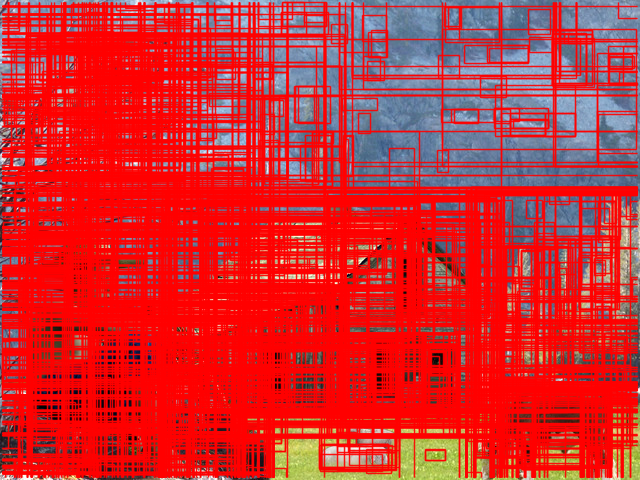

In [19]:
showrects(image3, selectivesearch(image3))

In [0]:
def filter_rects(rects, min_size=30, max_size = 400):
  """ 
  filter_rects: prend en argument une liste de rectangles et renvoie une liste contenant uniquement
  ceux dont les côtés sont de taille comprise entre min_size et max_size.
  """
  rects = [(x, y, w, h) for (x, y, w, h) in rects if min(w,h) > min_size and max(w,h) < max_size]
  return rects

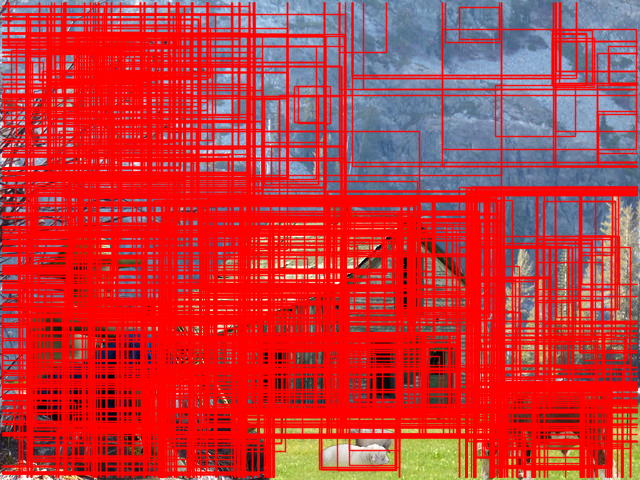

In [21]:
showrects(image3, filter_rects(selectivesearch(image3)))

## 2.2. Prediction

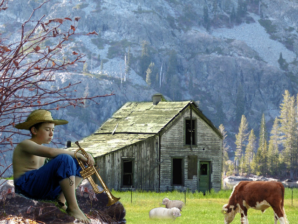

In [22]:
# On importe le modèle pour prédire les catégories
# N'importe quel modèle prévu pour ImageNet peut être
# utilisé ici.
from torchvision import  models,transforms
import torch

net = models.alexnet(pretrained=True)
net.eval()

# transformation de l'image au format 224x224 attendu
# par le modèle
resize = transforms.Compose([
                                 transforms.ToPILImage(),
                                 transforms.Resize(224)
])
# normalisation attendue par le modèle
transform = transforms.Compose([
      resize, 
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
])
# test de la transformation sur une image exemple.
resize(image3)

In [23]:
pred = net(transform(image3).unsqueeze(0))
pred.shape

torch.Size([1, 1000])

In [0]:
import torch.nn.functional as F
def get_labeled_boxes(img,maxRect=2000,threshold=.5,iou=0.5):
  """ 
  get_labeled_boxes : prend en argument
    - une image (img),
    - un nombre maximum de zones de prédictions à tester (maxRect),
    - un seuil d'acceptation d'une zone de prédiction (threshold)
    - un iou
  """
  predictions = []
  rects = selectivesearch(img)
  for i, rect in tqdm(enumerate(rects)):
    if(i > maxRect):
      break
    x, y, w, h = rect
    zone = img[y:y+h,x:x+w]
    with torch.no_grad():
      zone = transform(zone).unsqueeze(0)
      pred = net(zone)
      pred = F.softmax(pred)
      pred = pred.numpy().flatten()
      classi = np.argmax(pred)
      score = pred[classi]
    if(score <= threshold):
      continue
    predictions.append((rect, classi, score))
  
  return predictions

In [25]:
labeled_boxes = get_labeled_boxes(image3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [26]:
labeled_boxes[0]

(array([532, 400, 108,  80], dtype=int32), 339, 0.67606163)

In [27]:
print(len(labeled_boxes))

59


## 2.3. Refinement

In [0]:
# Importation des classes en format "humain"
!wget -q https://raw.githubusercontent.com/sarathknv/adversarial-examples-pytorch/master/fgsm/imagenet_labels.py -O imagenet_labels.py
import imagenet_labels
labels = imagenet_labels.classes

# fonction pour afficher une image et les objets detectés
def show_objs(img,labeled_regions):
  """ 
  - img : image
  - labeled_regions : triplets (rect,label,score) :
    - rect : quadruplet (x,y,w,h)
    - label : un entier entre 0 et 1000
    - score : un flottant entre 0 et 1
  """
  imOut = cv2.cvtColor(img.copy(),cv2.COLOR_RGB2BGR)
  
  for rect,label,score in labeled_regions:
      x, y, w, h = rect
      cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 0, 255), 1, cv2.LINE_AA)
      cv2.putText(imOut, "{} : {:.2f}".format(labels[label],score), (x,y+10),cv2.FONT_HERSHEY_SIMPLEX,.5,(255,0,0))
  cv2_imshow(imOut)

In [0]:
import torch.nn.functional as F
def IoU(rect1,rect2):
  """ 
  Renvoie un float avec le IoU entre rect1 et rect2 :
  rect1, rect2 : quadruplets (x,y,w,h) 
  """
  x1,y1,w1,h1 = rect1
  x2,y2,w2,h2 = rect2
  xA,yA = max(x1,x2),max(y1,y2)
  xB,yB = min(x1+w1,x2+w2),min(y1+h1,y2+h2)
  inter = max(0,xB - xA)*max(0,yB-yA)
  union = w1*h1 + w2*h2 - inter
  return inter/union

def get_labeled_boxes(img,maxRect=2000,threshold=.5,iou=0.5):
  """ 
  get_labeled_boxes : prend en argument
    - une image (img),
    - un nombre maximum de zones de prédictions à tester (maxRect),
    - un seuil d'acceptation d'une zone de prédiction (threshold)
    - un iou
  """
  predictions_raw = []
  rects = selectivesearch(img)
  for i, rect in tqdm(enumerate(rects)):
    if(i > maxRect):
      break
    x, y, w, h = rect
    zone = img[y:y+h,x:x+w]
    existed = False
    with torch.no_grad():
      zone = transform(zone).unsqueeze(0)
      pred = net(zone)
      pred = F.softmax(pred)
      pred = pred.numpy().flatten()
      classi = np.argmax(pred)
      score = pred[classi]
    if(score > threshold):
      predictions_raw.append((rect, classi, score))

  # print(predictions_raw[0])
  predictions_raw.sort(reverse=False, key=lambda x: x[2])
  # print(predictions_raw[0])
  predictions = []

  for i, labeled_region in enumerate(predictions_raw):
    existed = False
    for j in range(i+1, len(predictions_raw)):
      if(labeled_region[1] == predictions_raw[j][1]):
        if(IoU(labeled_region[0], predictions_raw[j][0]) > iou):
          existed = True
          break
    if not existed:
      predictions.append(labeled_region)
  
  return predictions

In [30]:
labeled_boxes = get_labeled_boxes(image3, iou=0.5, maxRect=2000, threshold=0.5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


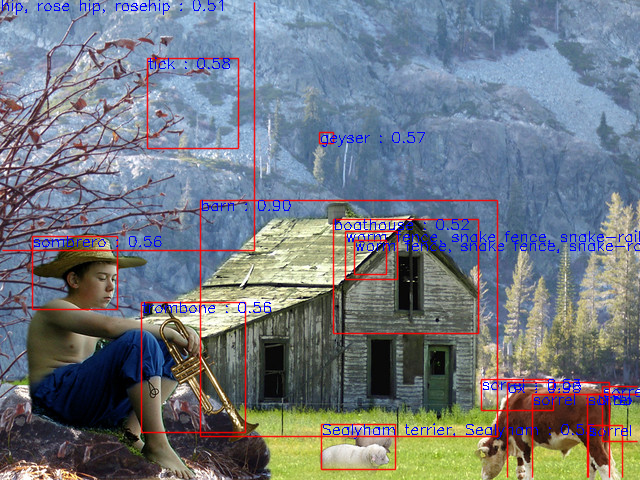

16


In [31]:
show_objs(image3, labeled_boxes)
print(len(labeled_boxes))

In [0]:
# Processing regions as batches and applying cuda() in the model

from torch.utils.data import Dataset

# Resizing all regions to (224,224) so that they can be put in a batch together
resize = transforms.Compose([
                                 transforms.ToPILImage(),
                                 transforms.Resize((224,224))
])
# normalisation attendue par le modèle
transform = transforms.Compose([
      resize, 
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
])

class RegionDataset(Dataset):
  def __init__(self, rects, image, transform=None):
    self.rects = rects
    self.image = image
    self.transform = transform
    # print(type(self.rects))
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    x, y, w, h = self.rects[idx]
    region = self.image[y:y+h,x:x+w]
    if(self.transform):
      region = self.transform(region)
      # print(region.shape)

    sample = {'rect': (x,y,w,h), 'region': region}

    return sample

  def __len__(self):
    # print(type(self.rects))
    return len(self.rects)

def get_labeled_boxes(img,maxRect=2000,threshold=.5,iou=0.5, use_cuda=True):
  """ 
  get_labeled_boxes : prend en argument
    - une image (img),
    - un nombre maximum de zones de prédictions à tester (maxRect),
    - un seuil d'acceptation d'une zone de prédiction (threshold)
    - un iou
  """
  predictions_raw = []
  regions = RegionDataset(selectivesearch(img), img, transform=transform)
  regions = torch.utils.data.DataLoader(regions, batch_size=32)

  for batch in regions:
    rect = batch['rect']
    rect = [i.numpy() for i in rect]
    # print(len(rect)
    # print(rect[0])
    region = batch['region']
    if use_cuda and torch.cuda.is_available():
      region = region.cuda()
    
    with torch.no_grad():
      pred = net(region)
      pred = F.softmax(pred, 1)
      # print(pred.shape)
      classi = torch.argmax(pred, 1)
      # print(classi.shape)
      classi = classi.detach().cpu().numpy()
      score = torch.max(pred, 1, keepdim=True)[0]
      # print(score.shape)
      score = score.detach().cpu().numpy().flatten()
      # print(score.shape)
      
    predictions_raw +=[((x,y,w,h), cls, scr) for x,y,w,h,cls,scr in zip(rect[0],
                                                                        rect[1],
                                                                        rect[2],
                                                                        rect[3],
                                                                        classi,
                                                                        score)
                                              if scr > threshold]
  ##########################
  ##Select labeled regions##
  ##########################
  print(predictions_raw[0])
  predictions_raw.sort(reverse=False, key=lambda x: x[2])
  print(predictions_raw[0])
  predictions = []

  for i, labeled_region in enumerate(predictions_raw):
    existed = False
    for j in range(i+1, len(predictions_raw)):
      if(labeled_region[1] == predictions_raw[j][1]):
        if(IoU(labeled_region[0], predictions_raw[j][0]) > iou):
          existed = True
          break
    if not existed:
      predictions.append(labeled_region)

  return predictions

In [33]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
  net.cuda()
labeled_boxes = get_labeled_boxes(image3, iou=.3, threshold=0.7)

((215, 234, 263, 179), 425, 0.7379864)
((474, 192, 166, 288), 339, 0.70323163)


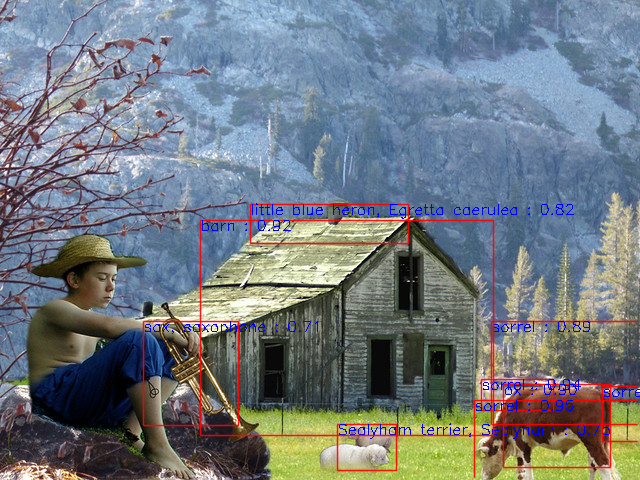

9


In [34]:
show_objs(image3, labeled_boxes)
print(len(labeled_boxes))

Reseizing selected regions to (224, 224) with fine-tuned threshold and iou brings back the better result than reseizing to (224,)